**The Boston Housing Prices project**

 I'll attempt to predict the median price of homes in a given Boston suburb in the
 mid-1970s, given data points about the suburb at the time, such as the crime rate, the
 local property tax rate, and so on.

Loading the Boston housing dataset

In [2]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

 Let’s look at the data:

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

As you can see, you have 404 training samples and 102 test samples, each with 13
 numerical features, such as per capita crime rate, average number of rooms per dwell
ing, accessibility to highways, and so on.
 The targets are the median values of owner-occupied homes, in thousands of
 dollars:

In [5]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

Preparing the data

 It would be problematic to feed into a neural network values that all take wildly differ
ent ranges. The network might be able to automatically adapt to such heterogeneous
 data, but it would definitely make learning more difficult. A widespread best practice
 to deal with such data is to do feature-wise normalization: for each feature in the input
 data (a column in the input data matrix), you subtract the mean of the feature and
 divide by the standard deviation, so that the feature is centered around 0 and has a
 unit standard deviation. This is easily done in Numpy.

In [6]:
mean = train_data.mean(axis=0)
train_data-= mean
std = train_data.std(axis=0)
train_data /= std
test_data-= mean
test_data /= std

 Because so few samples are available, you’ll use a very small network with two hidden
 layers, each with 64 units. In general, the less training data you have, the worse overfit
ting will be, and using a small network is one way to mitigate overfitting.

Model definition

In [7]:
from keras import models
from keras import layers

In [8]:
def build_model():
     model = models.Sequential()
     model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
     model.add(layers.Dense(64, activation='relu'))
     model.add(layers.Dense(1))
     model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
     return model

The network ends with a single unit and no activation (it will be a linear layer). This is
 a typical setup for scalar regression (a regression where you’re trying to predict a single
 continuous value). Applying an activation function would constrain the range the out
put can take; for instance, if you applied a sigmoid activation function to the last layer,
 the network could only learn to predict values between 0 and 1. Here, because the last
 layer is purely linear, the network is free to learn to predict values in any range.

I compile the network with the mse loss function—mean squared error,
 the square of the difference between the predictions and the targets. This is a widely
 used loss function for regression problems.
I'm also monitoring a new metric during training: mean absolute error (MAE). It’s
 the absolute value of the difference between the predictions and the targets. For
 instance, an MAE of 0.5 on this problem would mean my predictions are off by $500
 on average.

**Validating your approach using K-fold validation**

To evaluate my network while I keep adjusting its parameters (such as the number
 of epochs used for training), I could split the data into a training set and a valida
tion set but because I have so few data points,
 the validation set would end up being very small (for instance, about 100 examples).
 
 As a consequence, the validation scores might change a lot depending on which data
 points I chose to use for validation and which I chose for training: the validation
 scores might have a high variance with regard to the validation split. This would prevent me from reliably evaluating my model.

 The best practice in such situations is to use K-fold cross-validation.
 It consists of splitting the available data into K partitions (typically K = 4 or 5), instanti
ating K identical models, and training each one on K – 1 partitions while evaluating on
 the remaining partition. The validation score for the model used is then the average of
 the K validation scores obtained. 

**K-fold validation**

In [9]:
import numpy as np
k=4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
   print('processing fold #', i)
   val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
   val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
   partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
      train_data[(i + 1) * num_val_samples:]],
      axis=0)
   partial_train_targets = np.concatenate(
   [train_targets[:i * num_val_samples],
   train_targets[(i + 1) * num_val_samples:]],
   axis=0)
   model = build_model()
   model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=0)
   val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
   
   all_scores.append(val_mae)

processing fold # 0


c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


processing fold # 1
processing fold # 2
processing fold # 3


In [10]:
all_scores

[2.227891683578491, 3.1611335277557373, 2.696721076965332, 2.5800299644470215]

In [11]:
np.mean(all_scores)

2.6664440631866455

The different runs do indeed show rather different validation scores, from 2.6 to 3.2.
 The average (3.0) is a much more reliable metric than any single score—that’s the
 entire point of K-fold cross-validation. In this case, I'm off by $3,000 on average,
 which is significant considering that the prices range from $10,000 to $50,000.
 Let’s try training the network a bit longer: 500 epochs. To keep a record of how
 well the model does at each epoch, I’ll modify the training loop to save the per
epoch validation score log.

**Saving the validation logs at each fold**

In [13]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
          [train_data[:i * num_val_samples],
          train_data[(i + 1) * num_val_samples:]],
          axis=0)
    partial_train_targets = np.concatenate(
         [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
         axis=0)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [14]:
model = build_model()
history = model.fit(partial_train_data, partial_train_targets,
          validation_data=(val_data, val_targets),
          epochs=num_epochs, batch_size=1)


Epoch 1/500
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 369.2245 - mae: 16.2514 - val_loss: 65.0387 - val_mae: 5.6517
Epoch 2/500
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 27.6944 - mae: 3.5677 - val_loss: 39.1345 - val_mae: 4.2670
Epoch 3/500
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.3645 - mae: 2.5721 - val_loss: 29.3395 - val_mae: 3.4037
Epoch 4/500
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.3452 - mae: 2.5316 - val_loss: 24.7835 - val_mae: 3.0161
Epoch 5/500
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11.4069 - mae: 2.3580 - val_loss: 23.2262 - val_mae: 2.9057
Epoch 6/500
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.6052 - mae: 2.4151 - val_loss: 25.8403 - val_mae: 3.0252
Epoch 7/500
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.8892 - mae: 2.3105 - val_loss: 26.0477 - val_mae: 3.1351
Epoch 8/500
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.1651 - mae: 2.2101 - val_loss: 20.9558 - val_mae: 2.7648
Epoch 9/500
303/303 ━━━━━━━━━━

In [15]:
mae_history = history.history['val_mae']
all_mae_histories.append(mae_history)

Building the history of successive mean K-fold validation scores

In [16]:
average_mae_history = [
     np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Plotting validation scores

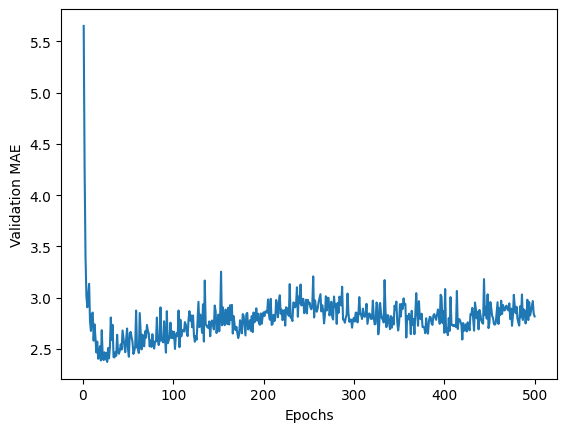

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a little difficult to see the plot, due to scaling issues and relatively high vari
ance. Let’s do the following:
  Omit the first 10 data points, which are on a different scale than the rest of the curve.
  Replace each point with an exponential moving average of the previous points,
 to obtain a smooth curve.

Plotting validation scores, excluding the first 10 data points

In [18]:
def smooth_curve(points, factor=0.9):
   smoothed_points = []
   for point in points:
      if smoothed_points:
        previous = smoothed_points[-1]
        smoothed_points.append(previous * factor + point * (1- factor))
      else:
        smoothed_points.append(point)
   return smoothed_points

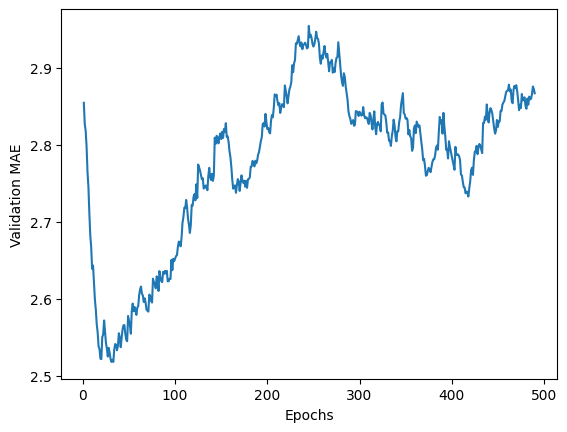

In [19]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving significantly after 40 epochs.
 Past that point, you start overfitting.
 Once I'm finished tuning other parameters of the model (in addition to the
 number of epochs, I could also adjust the size of the hidden layers), I can train a
 final production model on all of the training data, with the best parameters, and then
 look at its performance on the test data.

**Training the final model**

In [31]:
model = build_model()
model.fit(train_data, train_targets,
      epochs=70, batch_size=16)

Epoch 1/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 579.8539 - mae: 22.1245   
Epoch 2/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 427.9486 - mae: 18.8632 
Epoch 3/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 285.1855 - mae: 14.6777 
Epoch 4/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130.5647 - mae: 9.0521
Epoch 5/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 71.6108 - mae: 6.3228  
Epoch 6/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38.1119 - mae: 4.3742
Epoch 7/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.6295 - mae: 3.7932 
Epoch 8/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.5190 - mae: 3.4206 
Epoch 9/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.3800 - mae: 3.3075 
Epoch 10/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.1785 - mae: 2.8596 
Epoch 11/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.1077 - mae: 2.8131 
Epoch 12/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.7687 - mae: 2.6718 
Epoch 13/70
26/26

Here’s the final result:

In [32]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.1497 - mae: 2.4829 


2.68693208694458

 You’re still off by about $2,690.